# Demonstration of Automatic Data Processing with default solvers (QSS and OSQP)

## Clean data set example from Constellation database

8/7/23

This notebook demonstrates the newly added support for the QSS solver. The SDT pipeline uses QSS by default for nonconvex signal decomposition, and OSQP for convex ones.

### Notebook setup and library imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set(font_scale=0.8)
# PVInsight Code Imports
from solardatatools import DataHandler
from solardatatools.dataio import load_constellation_data

### Load data table from Constellation database

In [3]:
data_frame = load_constellation_data(file_id=5000)

In [4]:
data_frame.head()

,ac_energy_inv_2003,ac_energy_inv_2004,ac_energy_meter_1,ac_energy_meter_1_2,ac_energy_meter_1_3,ac_energy_meter_2,ac_energy_meter_2_2,ac_energy_meter_2_3,ac_power_inv_2003,ac_power_inv_2004,ac_power_meter_1,ac_power_meter_2,ac_voltage_inv_2003,ac_voltage_inv_2004,cabinet_temp_o_970,dc_current_inv_2003,dc_current_inv_2004,dc_power_inv_2003,dc_power_inv_2004,dc_voltage_inv_2003,dc_voltage_inv_2004,iac_inv_2003,iac_inv_2004,irradiance_ghi_o_970,irradiance_poa_o_1,irradiance_poa_o_2,irradiance_poa_o_971,temperature_enclosure_o_1,temperature_enclosure_o_2,temperature_module_o_1,temperature_module_o_2,temperature_module_o_971
measured_on,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-03-03 10:00:00,NaN,0.0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.080889,-0.064000,NaN,NaN,493.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.115556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-03 10:15:00,NaN,0.0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.082133,-0.070400,NaN,NaN,493.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.108444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-03 10:30:00,NaN,0.0,NaN,-0.074667,NaN,NaN,NaN,NaN,NaN,0.059733,-0.065067,NaN,NaN,362.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.081778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-03 10:45:00,NaN,0.0,NaN,-0.160000,NaN,NaN,NaN,NaN,NaN,0.000000,-0.066133,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-03 11:00:00,NaN,0.0,NaN,-0.160000,NaN,NaN,NaN,NaN,NaN,0.040533,-0.075733,NaN,NaN,263.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.055111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Running the `DataHandler` processing pipeline

In [11]:
dh = DataHandler(data_frame)

The solver and solver_convex args are set to "QSS" and "OSQP", respectively, by default. To run with MOSEK, we only need to specify solver="MOSEK" and it will be used as the default for all signal decompositions.

In [39]:
dh.run_pipeline(power_col='ac_power_inv_2004', solver='QSS', solver_convex='OSQP', fix_shifts=True)

/Users/smiskov/opt/anaconda3/envs/pvi-dev/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/smiskov/opt/anaconda3/envs/pvi-dev/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


total time: 164.81 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              50.23s
Cleaning                   75.01s
Filtering/Summarizing      39.57s
    Data quality           2.53s
    Clear day detect       12.34s
    Clipping detect        8.65s
    Capacity change detect 16.05s



### Top-level reporting

First we view a quick summary of the data set. 

In [40]:
dh.report()


-----------------
DATA SET REPORT
-----------------
length               9.09 years
capacity estimate    100.94 kW
data sampling        15 minutes
quality score        0.92
clearness score      0.18
inverter clipping    False
clipped fraction     0.00
capacity changes     False
data quality warning True
time shift errors    True
time zone errors     False
            


We use heat maps to view the entire data set at once. This provides a much clearer picture of system performance and data set quality than trying to view the time series signal over multiple years.

The "raw" matrix is the initial embedding of the data table after infering the correct shape (number of data points per day by the number of full days) and standardizing the time axis. The white spaces are missing data.

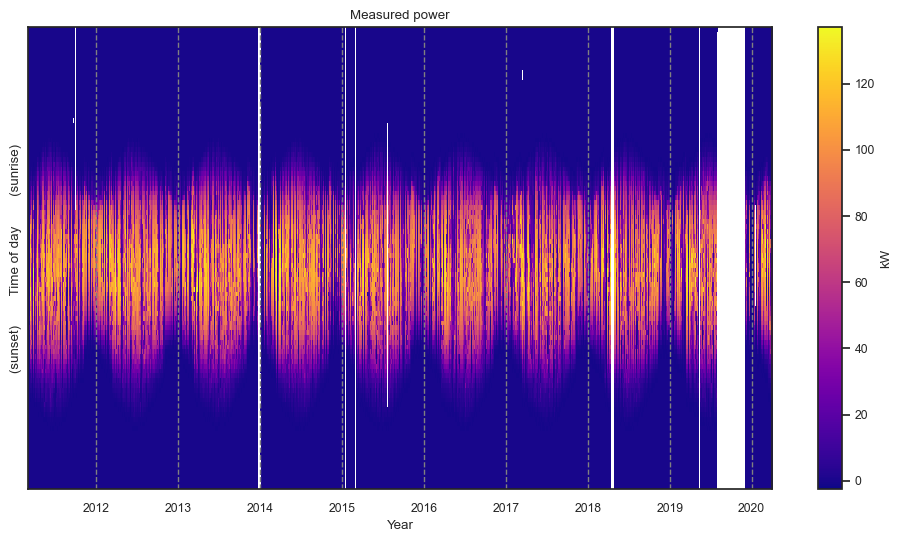

In [41]:
dh.plot_heatmap(matrix='raw');

The "filled" matrix is a formal matrix $M\in\mathbf{R}^{m\times n}$. All entries are real-valued. Night time values and missing days are filled with zeros. Gap within days are filled with linear interpolation.

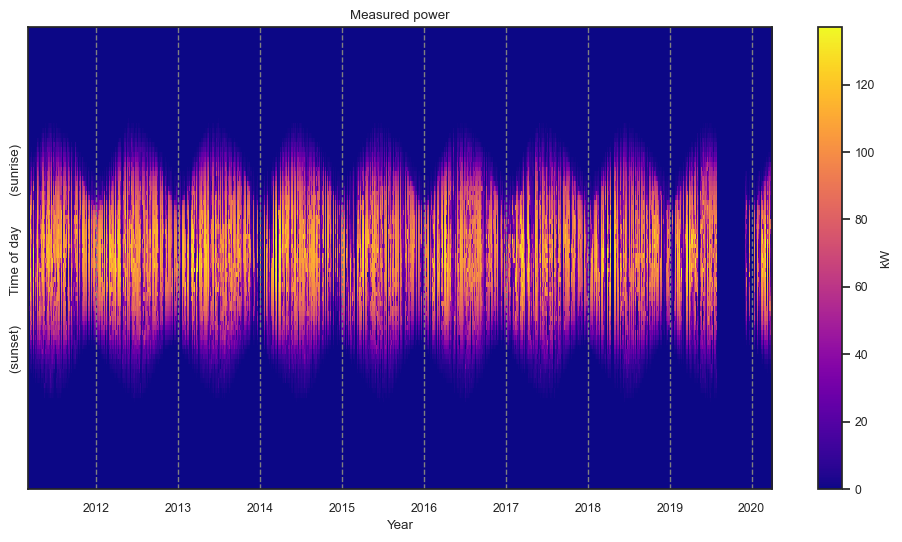

In [42]:
dh.plot_heatmap(matrix='filled', scale_to_kw=True);

### Access to data

Data is available in a number of formats. The first is the original tabular data used at class instantiation.

In [43]:
type(dh.data_frame)

pandas.core.frame.DataFrame

In [44]:
dh.data_frame.columns

Index(['ac_energy_inv_2003', 'ac_energy_inv_2004', 'ac_energy_meter_1',
       'ac_energy_meter_1_2', 'ac_energy_meter_1_3', 'ac_energy_meter_2',
       'ac_energy_meter_2_2', 'ac_energy_meter_2_3', 'ac_power_inv_2003',
       'ac_power_inv_2004', 'ac_power_meter_1', 'ac_power_meter_2',
       'ac_voltage_inv_2003', 'ac_voltage_inv_2004', 'cabinet_temp_o_970',
       'dc_current_inv_2003', 'dc_current_inv_2004', 'dc_power_inv_2003',
       'dc_power_inv_2004', 'dc_voltage_inv_2003', 'dc_voltage_inv_2004',
       'iac_inv_2003', 'iac_inv_2004', 'irradiance_ghi_o_970',
       'irradiance_poa_o_1', 'irradiance_poa_o_2', 'irradiance_poa_o_971',
       'temperature_enclosure_o_1', 'temperature_enclosure_o_2',
       'temperature_module_o_1', 'temperature_module_o_2',
       'temperature_module_o_971', 'seq_index'],
      dtype='object')

The second is the "raw" data matrix. This is a 2D `numpy.array` object created from the tabular data. Some entries may be missing if there was not a measurement reported for that timestamp in the data table.

In [45]:
dh.raw_data_matrix.shape

(96, 3317)

In [46]:
np.max(dh.raw_data_matrix)

nan

In [47]:
np.min(dh.raw_data_matrix)

nan

Finally, we have the "filled" data matrix. This 2D `numpy.array` has a real float value in every entry.

In [48]:
dh.filled_data_matrix.shape

(96, 3317)

In [49]:
np.max(dh.filled_data_matrix)

136.996262

In [50]:
np.min(dh.filled_data_matrix)

0.0

### Daywise filtering and selection

After running the pipeline, the class has an attribute which holds a number of boolian indices, each of a length equal to the number of days in the data set. The available flags to filter on are shown below.

In [51]:
dh.daily_flags.__dict__.keys()

dict_keys(['density', 'linearity', 'no_errors', 'clear', 'cloudy', 'inverter_clipped', 'capacity_cluster'])

In [52]:
dh.daily_flags.no_errors

array([False, False, False, ...,  True,  True,  True])

### Seasonal analysis using circular statistics

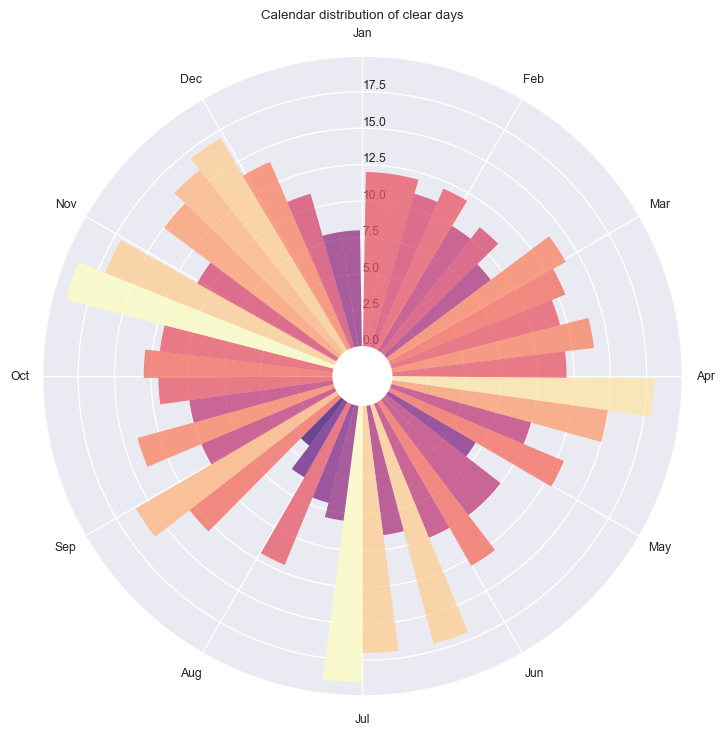

In [53]:
dh.plot_circ_dist(flag='clear');

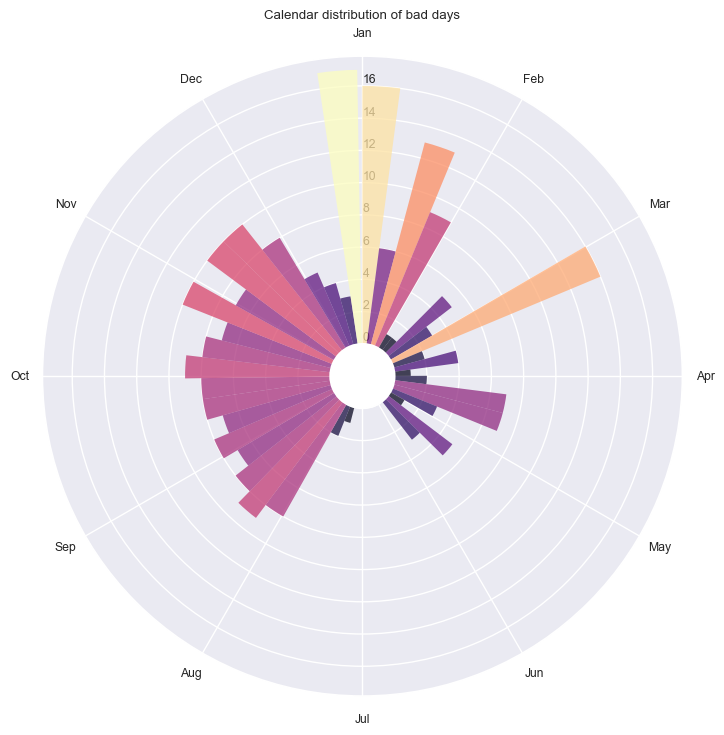

In [54]:
dh.plot_circ_dist(flag='bad');

### Views into the behavior of the algorithms

_Data quality flagging_

#### Clear Days

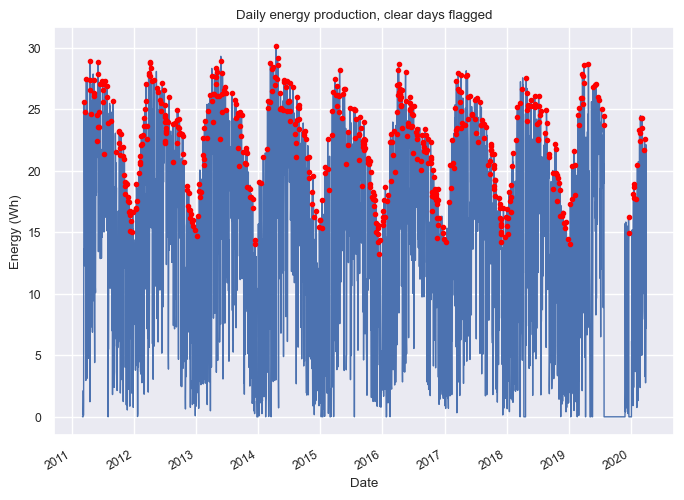

In [55]:
dh.plot_daily_energy(flag='clear');

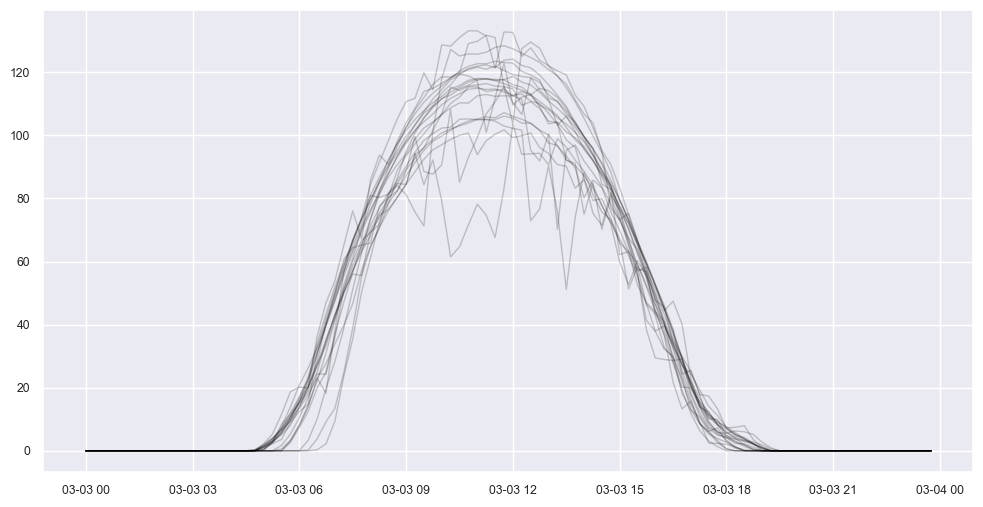

In [56]:
bix = dh.daily_flags.clear
dh.plot_daily_signals(boolean_index=bix, start_day=0, num_days=20, ravel=False, color='black', alpha=0.2);

#### Missing/corrupted data

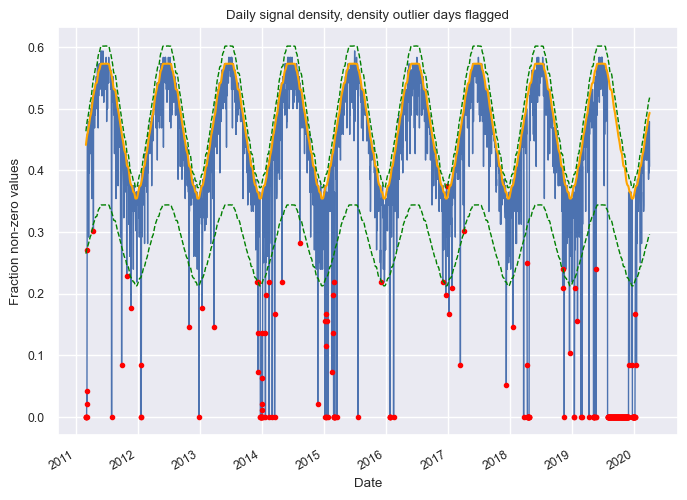

In [57]:
dh.plot_density_signal(show_fit=True, flag='density');

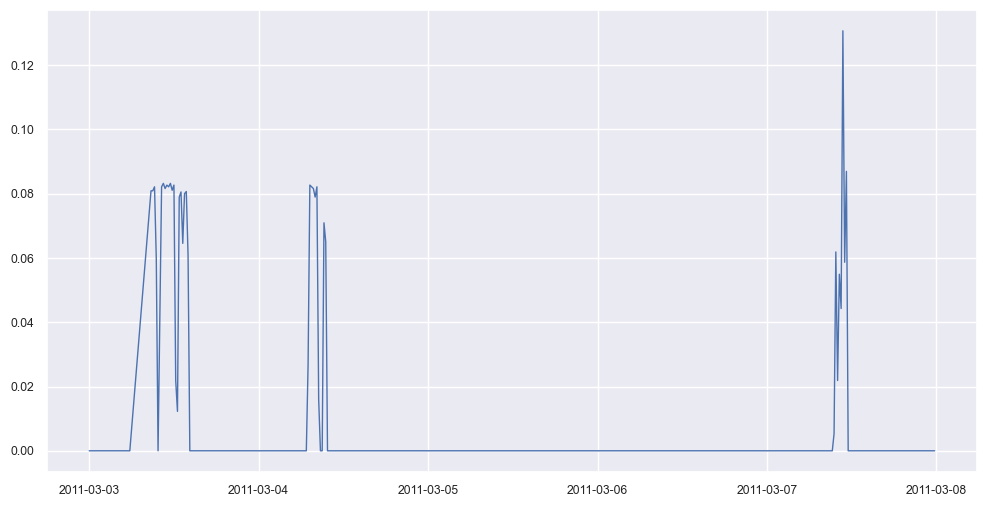

In [58]:
# Select days that failed the density test
bix = ~dh.daily_flags.density
dh.plot_daily_signals(boolean_index=bix, start_day=0, num_days=5, ravel=True);

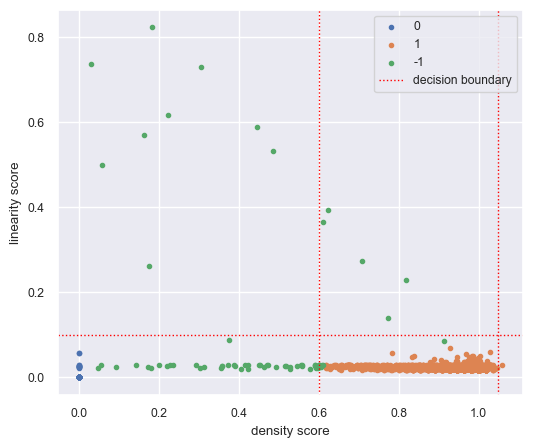

In [59]:
dh.plot_data_quality_scatter();

### Capacity change analysis

This analysis checks for abrupt step changes in the apparent capacity of the system.

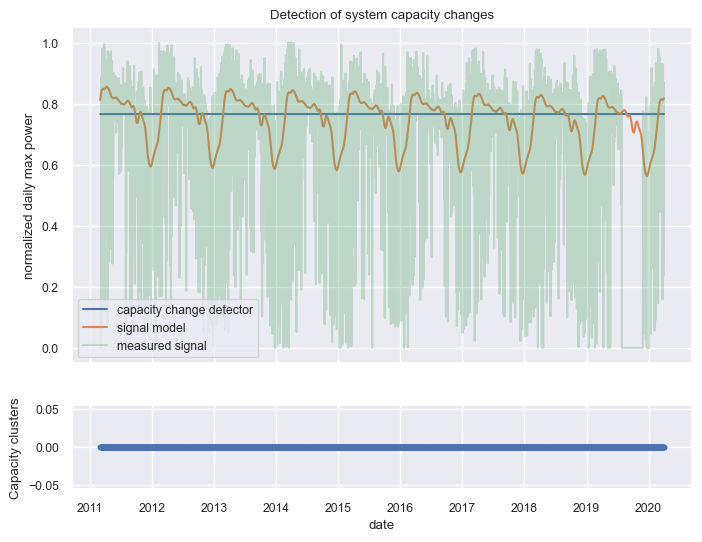

In [60]:
dh.plot_capacity_change_analysis();

### Clipping analysis

These plots show how clipped days are detected (none in this data set).

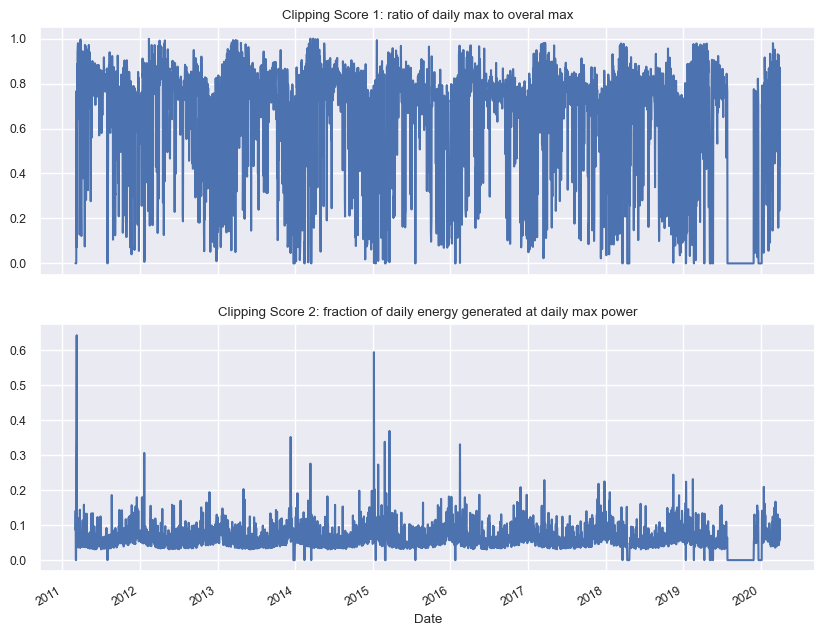

In [61]:
dh.plot_clipping();

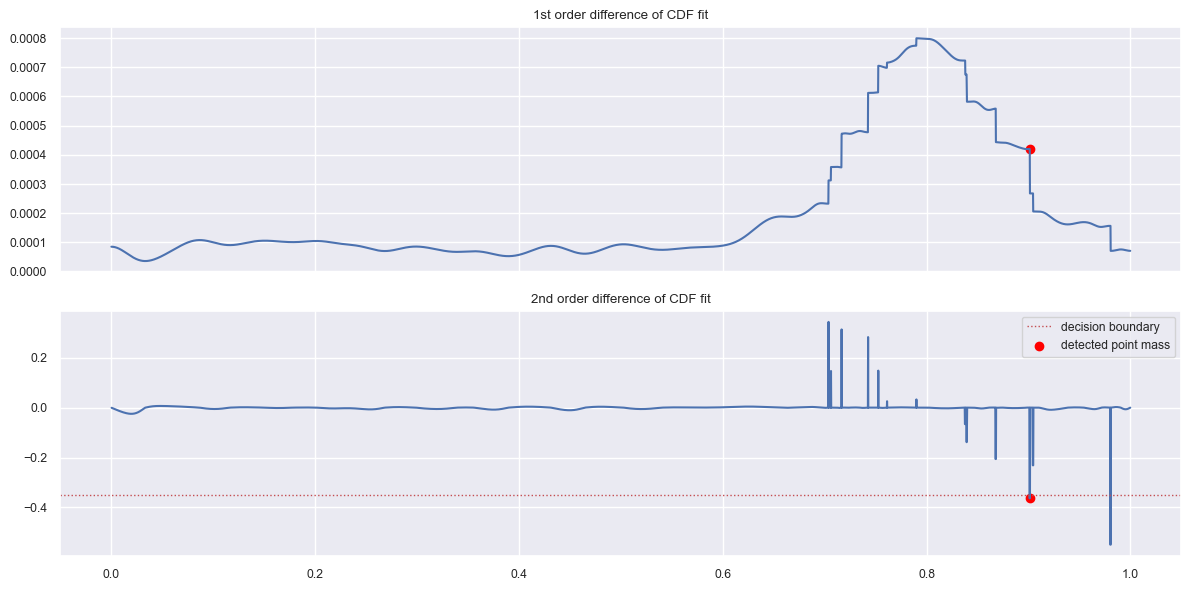

In [62]:
dh.plot_cdf_analysis();

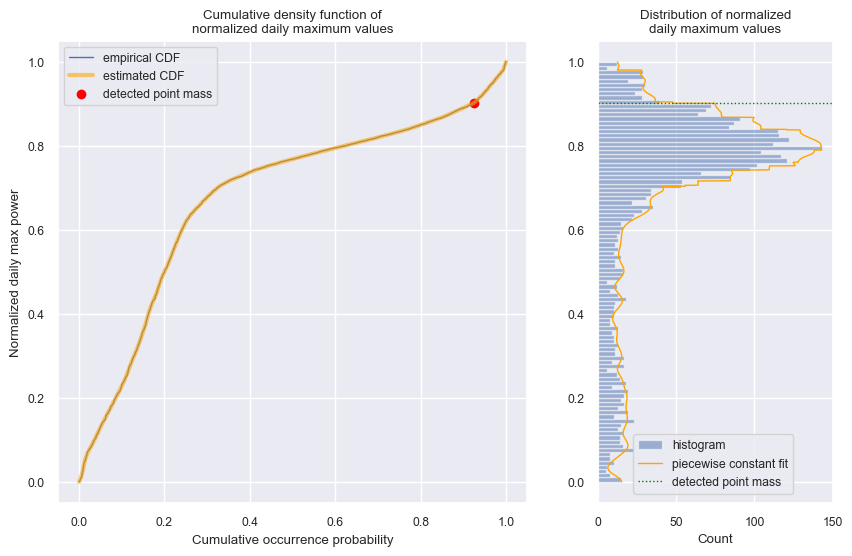

In [63]:
dh.plot_daily_max_cdf_and_pdf();

### Time shift analysis

These plots show the results of the time shift algorithm (none in this dataset).

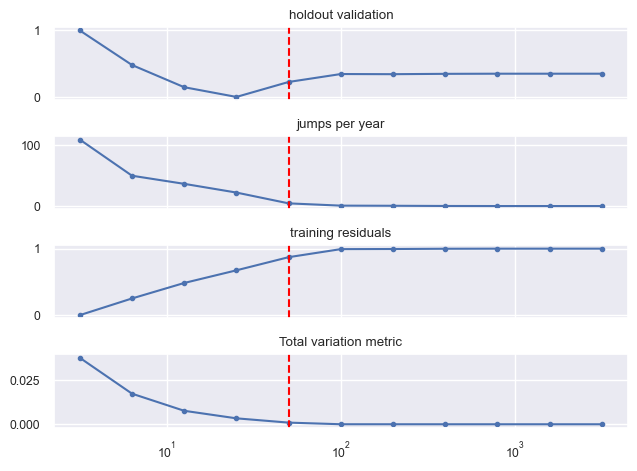

In [64]:
dh.time_shift_analysis.plot_optimization();

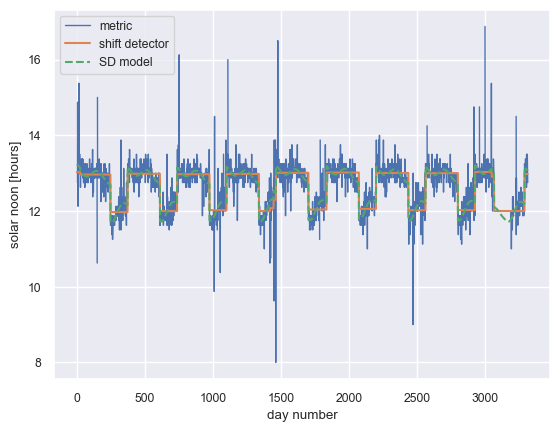

In [66]:
dh.time_shift_analysis.plot_analysis();